# Writing a Gradient Descent algorithm

This assignment is part of the [Calculus and Optimization](https://www.coursera.org/learn/calculus-and-optimization-for-machine-learning?#about) course offered by the Higher School of Economics (HSE) on Coursera.

We are given the **House Pricing** dataset, where there are a lot of information about houses and the target is the price of a house. The goal of this assignment is to find gradient formulas for each parameter of a linear model and then build a gradient descent algorithm for those parameters. The loss function will be the Mean Squared Error (MSE).


In [1]:
import numpy as np
import pandas as pd

## Reading and Preparing
---

In [32]:
X = np.load('x_train.npy')
y = np.log(np.load('y_train.npy'))

X = pd.DataFrame(X, columns=X.dtype.names)
HP = pd.concat([X, pd.Series(y, name='price')], axis=1)
HP

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,price
0,2014-09-16,5.0,3.25,3710,34200,2.0,False,3,8,2510,1200,1986,0,98074,47.610100,-122.046997,13.361380
1,2014-11-18,3.0,1.75,2820,8879,1.0,False,5,7,1540,1280,1920,1957,98146,47.509399,-122.375999,13.031782
2,2014-11-10,3.0,1.00,1240,239144,1.0,False,3,6,1240,0,1921,1992,98038,47.430302,-122.045998,12.363076
3,2015-04-16,4.0,2.50,2670,8279,2.0,False,3,7,2670,0,1999,0,98148,47.429199,-122.328003,12.936034
4,2014-07-23,3.0,2.25,2700,4025,2.0,False,4,8,1760,940,1907,0,98122,47.607399,-122.293999,13.222209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2014-05-21,4.0,2.75,2290,6120,2.0,False,4,7,2170,120,1926,0,98115,47.674599,-122.327003,13.818506
14996,2015-04-01,3.0,2.00,1430,9250,1.0,False,4,8,990,440,1983,0,98052,47.695202,-122.096001,13.142166
14997,2014-07-11,2.0,1.00,640,7768,1.0,False,3,6,640,0,1942,0,98106,47.514999,-122.359001,12.013701
14998,2014-05-15,3.0,1.00,1630,10304,1.0,False,5,7,1630,0,1953,0,98155,47.754799,-122.317001,12.899220


In [33]:
HP['waterfrontterfront'] = HP['waterfront'].astype('int64') 

Let's keep informative features

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

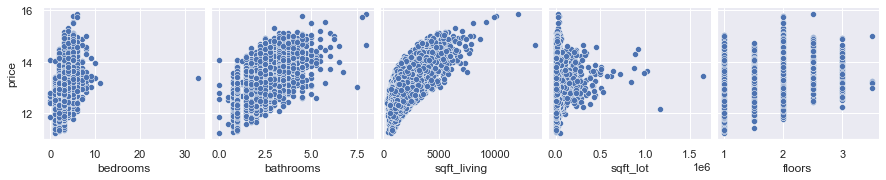

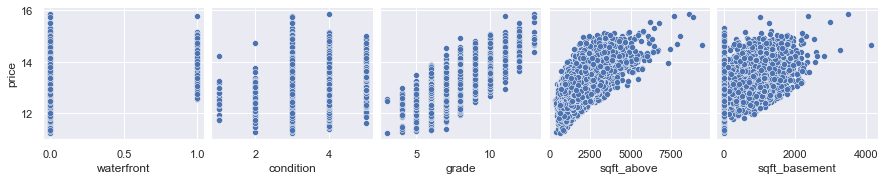

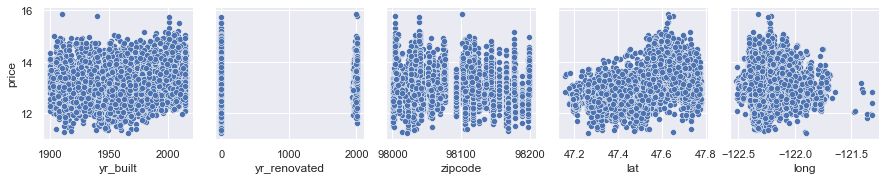

In [37]:
sns.pairplot(HP, x_vars =['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors'],
             y_vars=['price'], diag_kind=None)
sns.pairplot(HP, x_vars =['waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement'],
             y_vars=['price'], diag_kind=None)
sns.pairplot(HP, x_vars =['yr_built', 'yr_renovated', 'zipcode', 'lat', 'long'],
             y_vars=['price'], diag_kind=None)

Let us say, that we choose to work the following set of features:
+ `bedrooms`
+ `bathrooms`
+ `sqft_living`
+ `floors`
+ `condition`
+ `grade`
+ `sqft_above`
+ `sqft_basement`
+ `long`
+ `lat`


In [42]:
X = X[['bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'long', 'lat']].values

# Number of training examples
N = len(X)

# Number of features
m = X.shape[1]

## The model and its loss function
---
+ We have input data that is denoted as $\vec{x}_1, \vec{x}_2, \ldots, \vec{x}_N$
+ House prices for this input data are known $y_1, y_2, \ldots, y_N$

We propose a **simple linear model** for this task:

$$ \hat{y}_i=w_0+w_1x_1+w_2x_2+\ldots+w_mx_m $$

As a loss function we will use the mean squared error (**MSE**):

$$
Loss(\vec{w})=\frac{1}{N}\sum_{i=1}^N (y_i-\hat{y}_i)^2
$$

Note that we could directly find optimal parameters by computing : $$\hat{w} = (X^TX)^{-1}X^Ty$$
But we are interested here in applying the gradient descent technique.
### Computation of the $Loss(\vec{w})$ function

In [107]:
def loss(w, X, y):
    
    X = np.concatenate((np.ones(N).reshape(-1,1), X), axis=1)
    y2 = np.dot(X, w)
    
    lossValue = sum((y - y2) **2) / N
    
    return lossValue


### Computation of the gradient of the $Loss(\vec{w})$

Here are the gradient coordinates of the $Loss(\vec{w})$, with $\vec{w} = (w_0, w_1, \ldots, w_N)$

#### For $w_0$:

$\frac{\partial Loss}{\partial w_0}=\frac{-2}{N}\sum_{j=1}^{N} (y_j-\hat{y}_j)$



#### For $w_i$ in {$w_1, w_2, .., w_N$} :

$\frac{\partial Loss}{\partial w_i}=\frac{-2}{N}\sum_{j=1}^{N} xi_j*(y_j-\hat{y}_j)$

($xi_j$ means the jth element of the ith column of matrix X)

### Write a function to compute the gradient of the Loss function in the given point

In [40]:
def grad(w_k, X, y):
    
    X = np.concatenate((np.ones(N).reshape(-1,1), X), axis=1)
    y2 = np.dot(X, w_k)
    
    lossGradient = -2 * np.mean(X.T * (y - y2), axis = 1) 
    
    return lossGradient


### Write gradient descent

We are going to write the gradient descent formula in our code:
$$
\vec{w}^{k+1}=\vec{w}^{k}-\alpha_k\cdot \nabla Loss(\vec{w}^{k})
$$

We are going to use a constant $\alpha_k=\alpha$ and we assume that the method should stop in two cases:
+ if the number of iterations is to high (`max_iter`)
+ if the length of the gradient is low enough (<`eps`) to call an extremum

In [45]:
def gradDescent(w_init, alpha, X, y, max_iter=300, eps=1e-2):
    
    losses = []
    weights = [w_init]
    
    curiter = 0
    w_k = weights[-1]
    
    grad_norm = np.linalg.norm(grad(w_k, X, y))
    
    while (curiter <= max_iter) & (grad_norm > eps):
        
        gradient = grad(w_k, X, y)
        
        w_k = w_k - alpha * (gradient / np.linalg.norm(gradient))
                             
        lossValue_k = loss(w_k, X, y)
        
        curiter+=1
        
        grad_norm = np.linalg.norm(gradient)
        
        weights.append(w_k)
        losses.append(lossValue_k)
        
    return weights, losses


We are going to experiment our gradient descent function with several alphas and intial values of weights.


#### With alpha = 0.01 and max_iter = 300

Optimal Weights:  [-1.41327241  1.70706286  1.84112697  0.73190834 -0.38602294 -1.23509875
  1.74544705 -0.73255196 -0.7323401   0.00967044 -0.17007007]
Final loss:  57.799242935603885


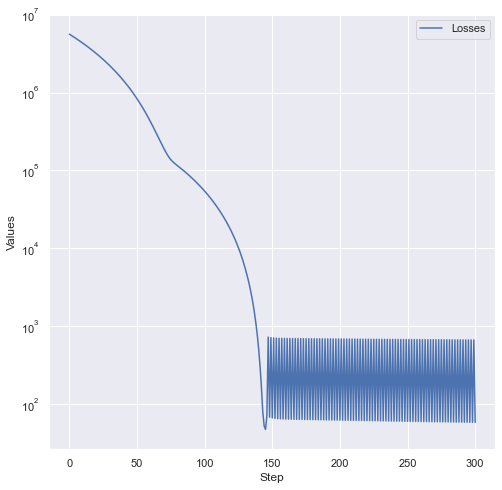

In [68]:
plt.figure(figsize=(8,8))

# We randomly initialize parameters 

weights, losses = gradDescent(np.random.randn(11,), 0.01, X, y, max_iter=300)

plt.plot(np.arange(len(losses)), losses, label='Losses')

plt.xlabel('Step')
plt.ylabel('Values')
plt.gca().set_yscale('log')
plt.legend()

print('Optimal Weights: ', weights[-1])
print('Final loss: ', losses[-1])

Our loss function decreases well but we can see that at some point of the process, it starts oscillating because the learning_rate is too high from this part. Let's put these final weights as intial values for another gradient descent algorithm, but this time with a much lower learning_rate. 

In [69]:
weights_to_intialize = weights[-1]

Optimal Weights:  [-1.41269178  1.70778739  1.84119808  0.73114389 -0.38559426 -1.23270636
  1.74821093 -0.73307406 -0.73258246 -0.0613486  -0.14245239]
Final loss:  7.8183471515332785


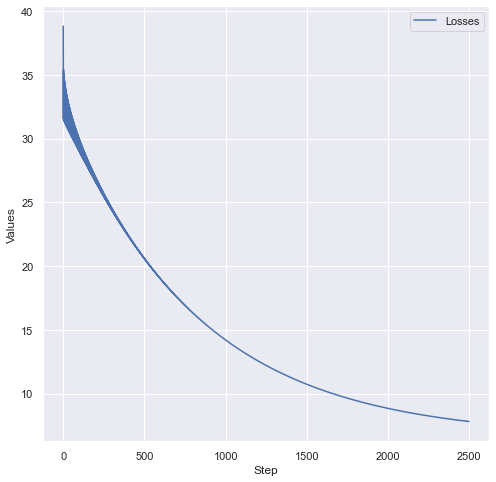

In [89]:
plt.figure(figsize=(8,8))

# We randomly initialize parameters 

weights, losses = gradDescent(weights_to_intialize, 0.0008, X, y, max_iter=2500)

plt.plot(np.arange(len(losses)), losses, label='Losses')

plt.xlabel('Step')
plt.ylabel('Values')
plt.legend()

print('Optimal Weights: ', weights[-1])
print('Final loss: ', losses[-1])

The weights of each feature in $$ \hat{y}_i=w_0+w_1x_1+w_2x_2+\ldots+w_mx_m $$ would be:

In [106]:
print('Coef of each feature:\n\n', sorted(zip(HP.drop('price', axis=1).columns,
                                                np.around(weights[-1], 3)),
                                          
                                       key=lambda x: np.abs(x[1]), reverse=True))

Coef of each feature:

 [('bathrooms', 1.841), ('waterfront', 1.748), ('bedrooms', 1.708), ('date', -1.413), ('floors', -1.233), ('condition', -0.733), ('grade', -0.733), ('sqft_living', 0.731), ('sqft_lot', -0.386), ('sqft_basement', -0.142), ('sqft_above', -0.061)]
